In [1]:
# ══ 1) Install / Upgrade Dependencies ════════════════════════════════════════
!pip install --upgrade pip
!pip install --quiet \
    opencv-python-headless \
    pandas \
    matplotlib \
    tqdm \
    scikit-learn \
    tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# ══ 2) Mount Google Drive ══════════════════════════════════════════════════
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# ══ 3) Imports & Global Settings ═══════════════════════════════════════════
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import pandas as pd
from sklearn.model_selection import train_test_split

# Paths & Hyperparameters
ROOT                 = '/content/drive/MyDrive/dataset/plantvillage dataset'
COLOR_DIR            = os.path.join(ROOT, 'segmented')
SAVE_DIR             = '/content/drive/MyDrive/saved_models_segmented_prodv10'
IMG_SIZE             = (224, 224)
BATCH_SIZE           = 32
NUM_HEAD_EPOCHS      = 10
NUM_FINE_TUNE_EPOCHS = 20
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:

# ══ 3.1) Resume Helper & Callback Definition ════════════════════════════════
class EpochCheckpoint(Callback):
    """Save model and history after each epoch with unique names."""
    def __init__(self, save_dir, base_name):
        super().__init__()
        self.save_dir = save_dir
        self.base_name = base_name
        self.history_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        mpath = os.path.join(self.save_dir, f"{self.base_name}_{ep:02d}.h5")
        self.model.save(mpath)
        self.history_per_epoch.append(logs.copy() if logs else {})
        hpath = os.path.join(self.save_dir, f"history_{self.base_name}_{ep:02d}.pkl")
        with open(hpath, 'wb') as f:
            pickle.dump(self.history_per_epoch, f)


def find_last_checkpoint(save_dir, base_name):
    files = [f for f in os.listdir(save_dir) if re.match(f"{base_name}_\\d+\\.h5", f)]
    if not files:
        return None, None, 0
    epochs = [int(re.findall(r"(\\d+)", f)[0]) for f in files]
    last = max(epochs)
    mpath = os.path.join(save_dir, f"{base_name}_{last:02d}.h5")
    hpath = os.path.join(save_dir, f"history_{base_name}_{last:02d}.pkl")
    return mpath, hpath, last


In [5]:
# ══ 4) Data Generators & Dataset Splits ═══════════════════════════════════════
# 4.1) Build a DataFrame of all grayscale image paths + labels
file_paths, labels = [], []
for cls in os.listdir(COLOR_DIR):
    class_dir = os.path.join(COLOR_DIR, cls)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(cls)
df = pd.DataFrame({'filename': file_paths, 'class': labels})

# 4.2) Stratified split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# 4.3) Define data generators
train_datagen = ImageDataGenerator(
    rescale=1/255., rotation_range=20,
    width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True
)
test_val_datagen = ImageDataGenerator(rescale=1/255.)

# 4.4) Flow from DataFrame
train_ds = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
val_ds = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_ds = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
print(f"Found {NUM_CLASSES} classes. Samples → train: {train_ds.n}, val: {val_ds.n}, test: {test_ds.n}")

Found 43452 validated image filenames belonging to 38 classes.
Found 5432 validated image filenames belonging to 38 classes.
Found 5432 validated image filenames belonging to 38 classes.
Found 38 classes. Samples → train: 43452, val: 5432, test: 5432


In [6]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import MobileNetV2

# ══ 5) Build Base Model ══════════════════════════════════════════════════════
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# ══ 6) Stage-1: Head Training (Resumeable) ══════════════════════════════════
head_name = 'MobileNetV2_head'
mp, hp, e0 = find_last_checkpoint(SAVE_DIR, head_name)
if mp:
    print(f"Resuming head training from epoch {e0}")
    model.load_weights(mp)
    initial_ep = e0
else:
    print("Starting head training from scratch")
    initial_ep = 0
cb_head = [
    EarlyStopping(monitor='val_loss', patience=1, min_delta=1e-2,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6),
    EpochCheckpoint(SAVE_DIR, head_name)
]
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ep + NUM_HEAD_EPOCHS,
    initial_epoch=initial_ep,
    callbacks=cb_head
)
print(f"Head training complete. Latest checkpoint: {head_name}_{initial_ep+NUM_HEAD_EPOCHS:02d}.h5")


Starting head training from scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7754 - loss: 0.8892

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 12384s 9s/step - accuracy: 0.7755 - loss: 0.8889 - val_accuracy: 0.9168 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9232 - loss: 0.2420

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 535s 394ms/step - accuracy: 0.9232 - loss: 0.2420 - val_accuracy: 0.9242 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9372 - loss: 0.1945

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 529s 389ms/step - accuracy: 0.9372 - loss: 0.1945 - val_accuracy: 0.9207 - val_loss: 0.2366 - learning_rate: 0.0010
Head training complete. Latest checkpoint: MobileNetV2_head_10.h5


Stage 1 final → Train Acc: 0.9373, Val Acc: 0.9207
170/170 ━━━━━━━━━━━━━━━━━━━━ 1198s 7s/step - accuracy: 0.9281 - loss: 0.2269
Stage 1 final → Test Loss: 0.2231, Test Acc: 0.9282


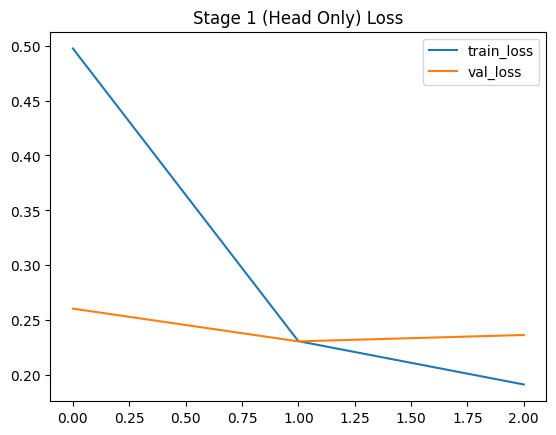

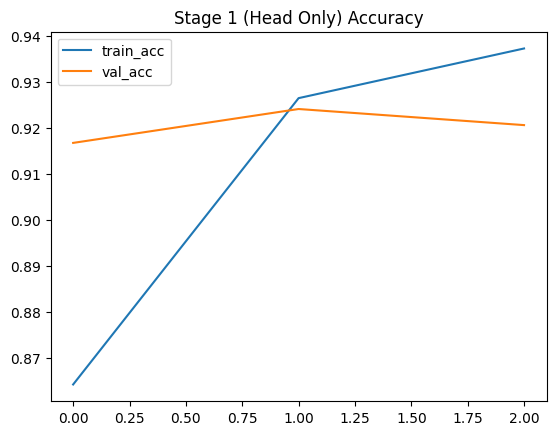

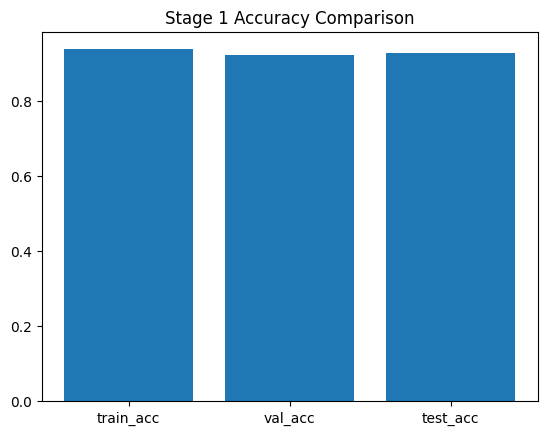

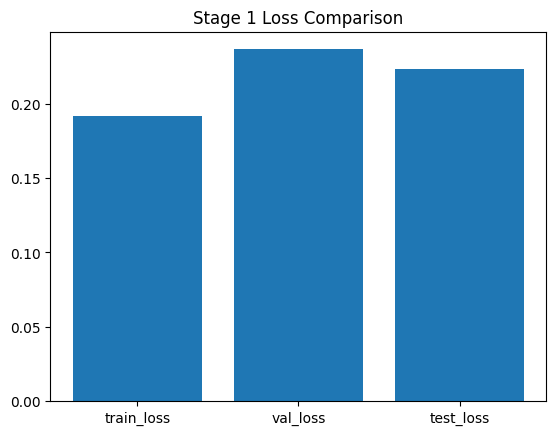

In [8]:
# ══ 8) Plot & Print Stage-1 Metrics & Test Evaluation ═════════════════════════════════════════
def plot_history(hist, stage):
    plt.figure()
    plt.plot(hist.history['loss'],     label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{stage} Loss');    plt.legend()
    plt.figure()
    plt.plot(hist.history['accuracy'],     label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{stage} Accuracy'); plt.legend()

# 8.1) Head-only training curves
plot_history(history1, 'Stage 1 (Head Only)')

train_acc1 = history1.history['accuracy'][-1]
val_acc1   = history1.history['val_accuracy'][-1]
print(f"Stage 1 final → Train Acc: {train_acc1:.4f}, Val Acc: {val_acc1:.4f}")

# 8.2) Evaluate head-only model on your held-out test set
test_loss1, test_acc1 = model.evaluate(test_ds, verbose=1)
print(f"Stage 1 final → Test Loss: {test_loss1:.4f}, Test Acc: {test_acc1:.4f}")

# 8.3) Bar-chart comparison for Stage 1
plt.figure()
plt.bar(['train_acc','val_acc','test_acc'], [train_acc1, val_acc1, test_acc1])
plt.title('Stage 1 Accuracy Comparison')
plt.show()

plt.figure()
plt.bar(
    ['train_loss','val_loss','test_loss'],
    [history1.history['loss'][-1], history1.history['val_loss'][-1], test_loss1]
)
plt.title('Stage 1 Loss Comparison')
plt.show()


In [9]:
# ══ 9) Stage-2: Fine-Tuning (Resumeable) ═══════════════════════════════════
for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_name = 'rMobileNetV2_finetuned'
mp2, hp2, e1 = find_last_checkpoint(SAVE_DIR, fine_name)
if mp2:
    print(f"Resuming fine-tuning from epoch {e1}")
    model.load_weights(mp2)
    initial_ft = e1
else:
    print("Starting fine-tuning from scratch")
    initial_ft = 0
cb_ft = [
    EarlyStopping(monitor='val_loss', patience=1,min_delta=1e-2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7),
    EpochCheckpoint(SAVE_DIR, fine_name)
]
history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ft + NUM_FINE_TUNE_EPOCHS,
    initial_epoch=initial_ft,
    callbacks=cb_ft
)
print(f"Fine-tuning complete. Latest checkpoint: {fine_name}_{initial_ft+NUM_FINE_TUNE_EPOCHS:02d}.h5")


Starting fine-tuning from scratch
Epoch 1/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7955 - loss: 0.7887

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 544s 390ms/step - accuracy: 0.7955 - loss: 0.7884 - val_accuracy: 0.9304 - val_loss: 0.2032 - learning_rate: 1.0000e-05
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9327 - loss: 0.2082

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 521s 384ms/step - accuracy: 0.9327 - loss: 0.2082 - val_accuracy: 0.9479 - val_loss: 0.1614 - learning_rate: 1.0000e-05
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9503 - loss: 0.1550

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 524s 385ms/step - accuracy: 0.9503 - loss: 0.1550 - val_accuracy: 0.9545 - val_loss: 0.1380 - learning_rate: 1.0000e-05
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9599 - loss: 0.1248

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 522s 384ms/step - accuracy: 0.9599 - loss: 0.1248 - val_accuracy: 0.9556 - val_loss: 0.1332 - learning_rate: 1.0000e-05
Fine-tuning complete. Latest checkpoint: rMobileNetV2_finetuned_20.h5


Stage 2 final → Train Acc: 0.9607, Val Acc: 0.9556
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9489 - loss: 0.1633
Stage 2 final → Test Loss: 0.1469, Test Acc: 0.9521


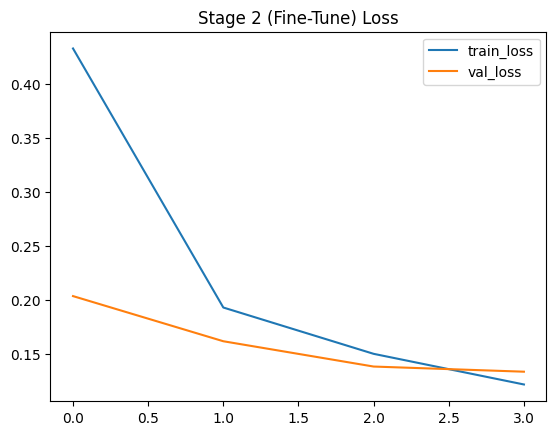

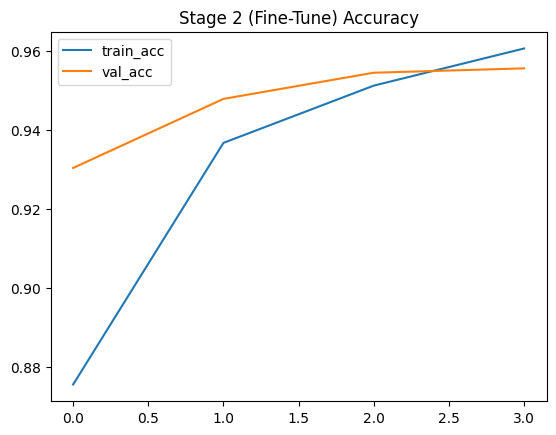

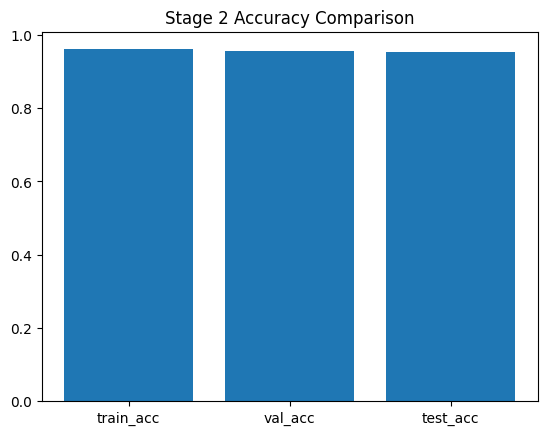

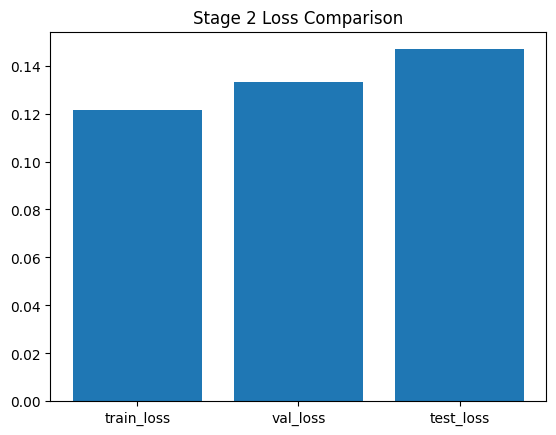

In [10]:
# ══ 10) Plot & Print Stage-2 Metrics & Test Evaluation ══════════════════════════
plot_history(history2, 'Stage 2 (Fine-Tune)')

train_acc2 = history2.history['accuracy'][-1]
val_acc2   = history2.history['val_accuracy'][-1]
print(f"Stage 2 final → Train Acc: {train_acc2:.4f}, Val Acc: {val_acc2:.4f}")

# 10.1) Evaluate on your held-out test set
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Stage 2 final → Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# 10.2) Comparison bar-charts
plt.figure()
plt.bar(['train_acc','val_acc','test_acc'], [train_acc2, val_acc2, test_acc])
plt.title('Stage 2 Accuracy Comparison')
plt.show()

plt.figure()
plt.bar(
    ['train_loss','val_loss','test_loss'],
    [history2.history['loss'][-1], history2.history['val_loss'][-1], test_loss]
)
plt.title('Stage 2 Loss Comparison')
plt.show()


In [11]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9508 - loss: 0.1414
Validation Loss: 0.1380, Validation Accuracy: 0.9545
